#  Data Science 100 - Final Group Report

GitHub: https://github.com/Jmmchai/Dsci-100-004-group02.git

In [20]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)
library(RColorBrewer)
options(repr.matrix.max.rows = 8)

# Introduction

In this project we are analyzing data from a video game research server, specifically a Minecraft Server. This project is run by a UBC Computer Science research group led by Frank Wood, and they are interested in collecting data about how people play video games. The server set up records players actions as they navigate the Minecraft world. 

The main problem is that, to ensure resources like server hardware and software licenses are sufficient, developers need to identify their main target audience, who they should dedicate resources to attract. This is why, we will analyze and wrangle the data to help them identify their target audience/players.

# 1. Questions

For this final report, we have decided to address the first general question, **"What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?**. 

Specifically, we will aim to answer the question: **Can we predict whether a player subscribes to the newsletter based on their age, experience, and total hours played from the *players* and *sessions* dataset?**

To answer our specific question, we have decided to use both the players and sessions dataset, which we will combine into one data set. 

# 2. Data Description

In [21]:
#read in players data
players <- read_csv("players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


The *players* dataset includes 196 rows, and 7 variables. These 7 variables include:

- **experience** (chr) &rarr; The expereince level of a player (Pro, Veteran, Beginner, Amateur, Regular)

- **subscribe** (lgl) &rarr; Whether a player is subscribed or not (TRUE/FALSE) 

- **hasedEmail** (chr) &rarr; the email each player uses 

- **played_hours** (dbl) &rarr; The number of hours played by each player 

- **name** (chr) &rarr; Each player's name 

- **gender** (chr) &rarr; Player's gender (Male, Female, Non-binary, Agender, Two-Spirited, Prefer not to say, Other) 

- **Age** (dbl) &rarr; Player's age

In [22]:
#read in sessions dataset
sessions <- read_csv("sessions.csv")
sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
⋮,⋮,⋮,⋮,⋮
7a4686586d290c67179275c7c3dfb4ea02f4d317d9ee0e2cee98baa27877a875,01/07/2024 04:08,01/07/2024 04:19,1.71981e+12,1.71981e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


The *sessions* dataset includes 1535 rows, and 5 variables. These 5 variables include:

- **hasedEmail** (chr) &rarr; the email each player uses 

- **start_time** (chr) &rarr; Start of playing time/session

- **end_time** (chr) &rarr; End of playing time/session

- **original_start_time** (dbl) &rarr; Start of playing session (in milliseconds)

- **original_end_time** (dbl) &rarr; End of playing session (in milliseconds)

In [23]:
#determine number of sessions and avg_session_time for each player
sessions_total_time <- sessions |>
                                mutate(start_time = as_datetime(start_time),
                                        end_time = as_datetime(end_time),
                                      duration = as.numeric(difftime(end_time, start_time, units = "mins"))) |>
                                group_by(hashedEmail) |>
                                summarise(num_sessions = n(),
                                          avg_session_duration = abs(mean(duration, na.rm = TRUE)))

#combine sessions and players datasets
players_sessions <- full_join(players, sessions_total_time)
players_sessions

Joining with `by = join_by(hashedEmail)`


experience,subscribe,hashedEmail,played_hours,name,gender,Age,num_sessions,avg_session_duration
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,27,4.854432e+05
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,3,1.416667e+00
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,1,8.333333e-02
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,1,8.333333e-01
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22,1,0.35000000
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57,1,0.08333333
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,6,0.49722222
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA,1,0.25000000


# 3. Data Visualizations

In [51]:
#select only variables of interest
selected_data <- players_sessions |>
                mutate(experience = as.numeric(experience)) |>
                select(experience, subscribe, played_hours, Age, num_sessions, avg_session_duration)
selected_data

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `experience = as.numeric(experience)`.
Caused by warning:
! NAs introduced by coercion”


experience,subscribe,played_hours,Age,num_sessions,avg_session_duration
<dbl>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
NA,TRUE,30.3,9,27,4.854432e+05
NA,TRUE,3.8,17,3,1.416667e+00
NA,FALSE,0.0,17,1,8.333333e-02
NA,TRUE,0.7,21,1,8.333333e-01
⋮,⋮,⋮,⋮,⋮,⋮
NA,FALSE,0.3,22,1,0.35000000
NA,FALSE,0.0,57,1,0.08333333
NA,FALSE,2.3,17,6,0.49722222
NA,TRUE,0.2,NA,1,0.25000000


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


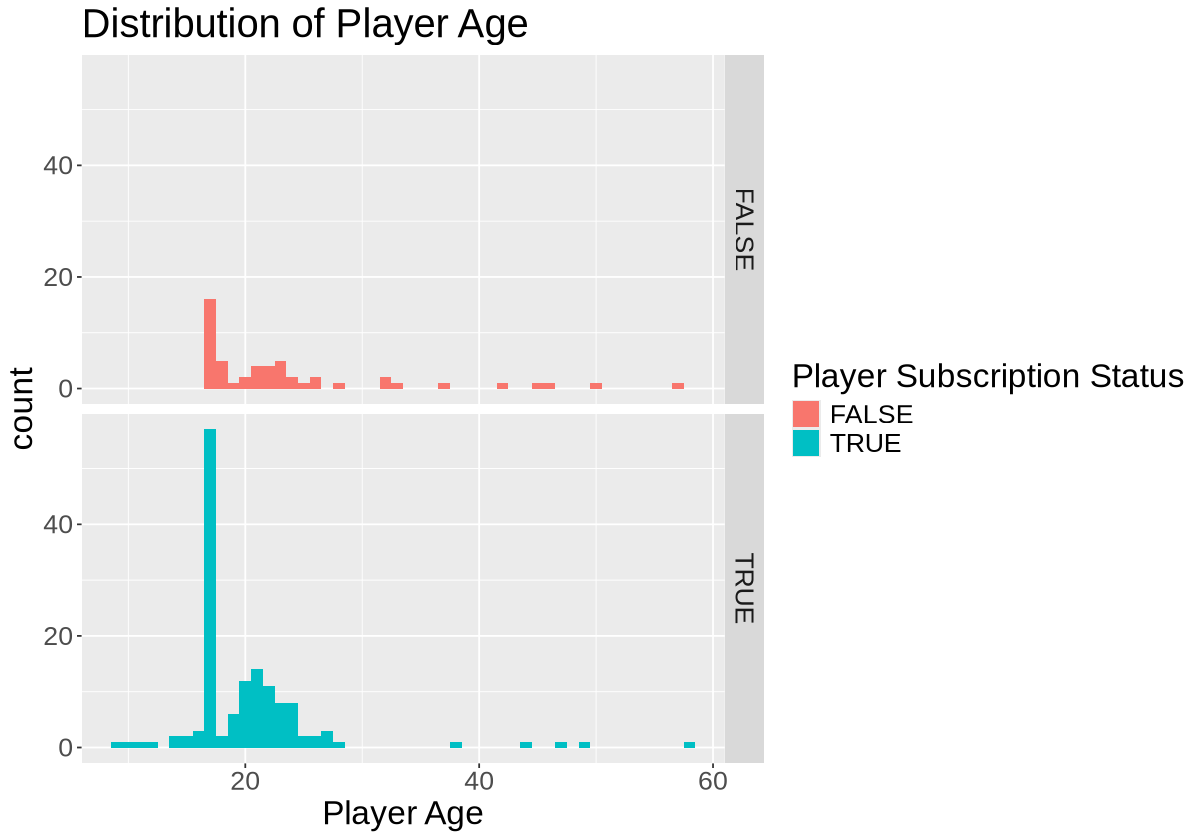

In [30]:
options(repr.plot.width = 10, repr.plot.length = 14)

#show distribution of age compared to experience
age_experience_dist <- selected_data |>
                        ggplot(aes(x = Age, fill = as.factor(subscribe)))+
                        geom_histogram(binwidth = 1)+
                        facet_grid(rows = vars(subscribe))+
                        labs(x = "Player Age", y = "count", fill = "Player Subscription Status")+
                        ggtitle("Distribution of Player Age")+
                        theme(text = element_text(size = 20))
age_experience_dist

From the above plot, we see that most players are between 15-25 years (with the most being around 18 years). We also see that a majority of the current players are subscribed, especially the players that lie in the 15-25 age group.

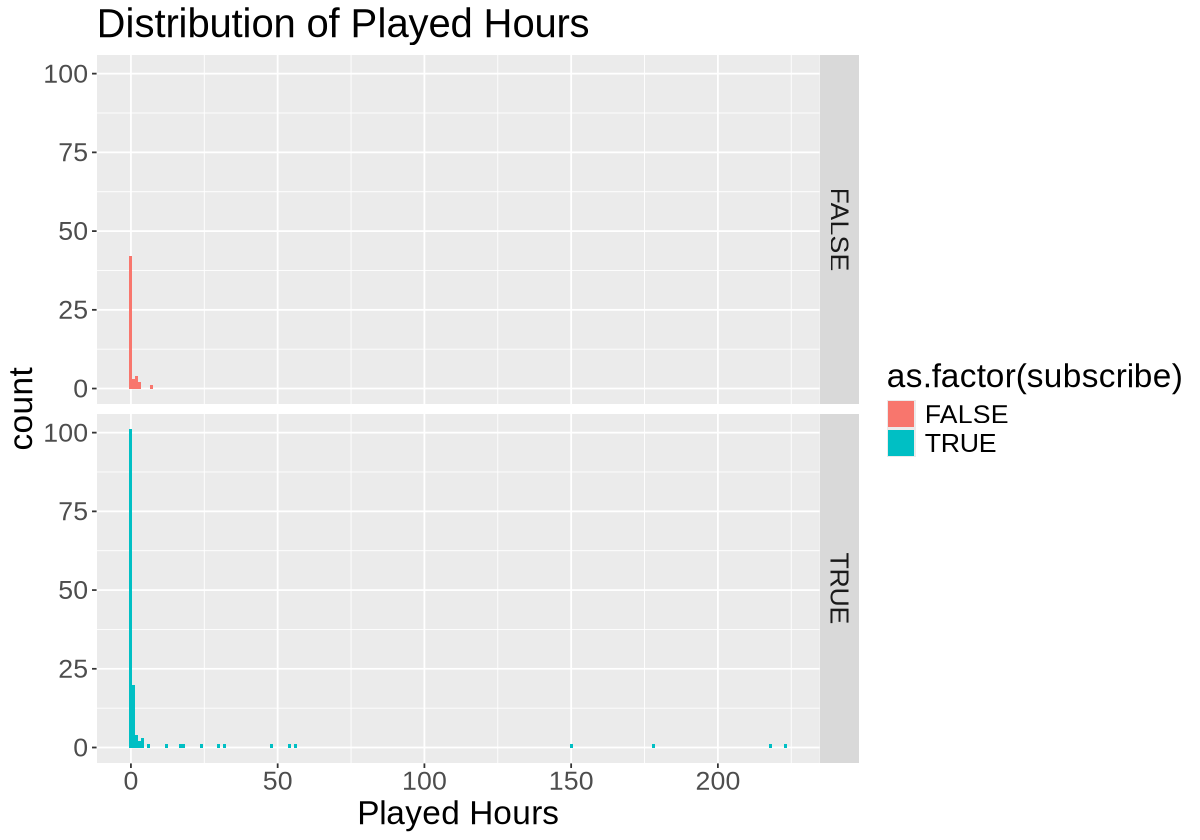

In [40]:
options(repr.plot.width = 10, repr.plot.length = 14)

#show distribution of played_hours
played_hours_dist <- selected_data |>
                    ggplot(aes(x = played_hours, fill = as.factor(subscribe)))+
                    geom_histogram(binwidth = 1)+
                    facet_grid(rows = vars(subscribe))+
                    labs(x = "Played Hours", y = "count")+
                    ggtitle("Distribution of Played Hours")+
                    theme(text = element_text(size = 20))
played_hours_dist

The above plot shows that there is no direct relationship between **played_hours** and **subscribe**, but we see that most of the players are subscribed. So, we can determine how many players are subscribed or not by using filter(). 

In [32]:
#determine number of subscribed players
number_subscribed <- selected_data |>
                    filter(subscribe == TRUE, na.rm = TRUE)
number_subscribed

number_not_subscribed <- selected_data |>
                        filter(subscribe == FALSE, na.rm = TRUE)
number_not_subscribed

experience,subscribe,played_hours,Age,num_sessions,avg_session_duration
<chr>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
Pro,TRUE,30.3,9,27,4.854432e+05
Veteran,TRUE,3.8,17,3,1.416667e+00
Amateur,TRUE,0.7,21,1,8.333333e-01
Regular,TRUE,0.1,21,1,1.500000e-01
⋮,⋮,⋮,⋮,⋮,⋮
Beginner,TRUE,0.0,17,NA,NA
Amateur,TRUE,0.0,20,NA,NA
Amateur,TRUE,0.0,17,NA,NA
Pro,TRUE,0.2,NA,1,0.25


experience,subscribe,played_hours,Age,num_sessions,avg_session_duration
<chr>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
Veteran,FALSE,0.0,17,1,0.08333333
Amateur,FALSE,0.0,21,1,0.08333333
Amateur,FALSE,0.0,22,NA,NA
Amateur,FALSE,0.1,17,1,0.20000000
⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,0.0,17,NA,NA
Veteran,FALSE,0.3,22,1,0.35000000
Amateur,FALSE,0.0,57,1,0.08333333
Amateur,FALSE,2.3,17,6,0.49722222


From the above wrangling, we determined that from the current 196 players, 144 are subscribed (73.5%) and 52 are not subscribed (26.5%). 

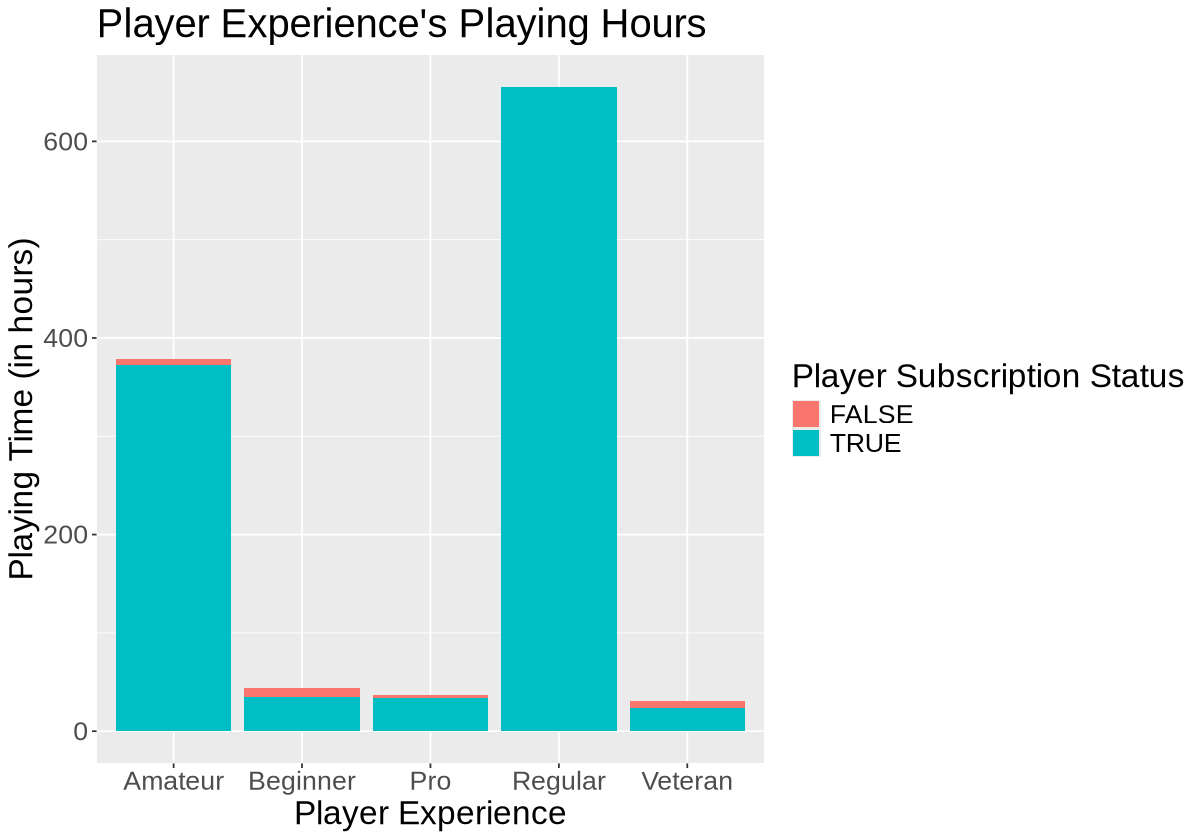

In [39]:
options(repr.plot.width = 10, repr.plot.length = 14)

#visualize relationship between experience and subscription
experience_subscription <- selected_data |>
                            ggplot(aes(x = experience, y = played_hours, fill = as.factor(subscribe)))+
                            geom_bar(stat = "identity")+
                            labs(x = "Player Experience", y = "Playing Time (in hours)", fill = "Player Subscription Status")+
                            ggtitle("Player Experience's Playing Hours")+
                            theme(text = element_text(size = 20))
experience_subscription

From the above graph we can make a few observations. First, we see that regular-experience players have the highest total playing time and subscription status, with almost all of them being subscribed. We can also see that amateur players have the second highest playing time and subscription status, with most of them being subscribed. 

The beginner, pro, and veteran players don't have a very high playing time, but most are subscribed (just not as much as regular and amateur players).

# 4. Methods

In [45]:
#split data into 75% training and 25% testing

players_sessions_split <- initial_split(selected_data, prop = 0.75, strata = subscribe)

players_sessions_training <- training(players_sessions_split)

players_sessions_testing <- testing(players_sessions_split)

In [50]:
#make classification model

players_spec <- nearest_neighbor(weight_fun = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

players_recipe <- recipe(subscribe ~ experience + played_hours + Age, data = selected_data) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

players_fit <- workflow() |>
                add_recipe(players_recipe) |>
                add_model(players_spec) |>
                fit(data = players_sessions_training)
players_fit

ERROR: [1m[33mError[39m in `step_scale()`:[22m
[1mCaused by error in `prep()`:[22m
[1m[22m[31m✖[39m All columns selected for the step should be double or integer.
[36m•[39m 1 factor variable found: `experience`
